**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

## 大変お世話になったページ

- [Kaggle](https://kaggle.com)
- [【Kaggle】「House Prices」をパクりながらやってみた。](https://qiita.com/muscle_nishimi/items/901ed94f3cdf1c8d893a)
- [「データ前処理」- Kaggle人気チュートリアル](https://qiita.com/hkthirano/items/12e046b3e02961d8460d)

In [5]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

Here's some of the code you've written so far. Start by running it again.

In [336]:
# Import helpful libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

pd.set_option('display.max_columns', 100)

# Load the data, and separate the target
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)

# Load the test data
# path to file you will use for predictions
test_data_path = '../input/test.csv'
# read test data file using pandas
test_data = pd.read_csv(test_data_path)

In [337]:
var = 'SalePrice'
drop_index = home_data[home_data[var]>700000].index
home_data = home_data.drop(drop_index)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


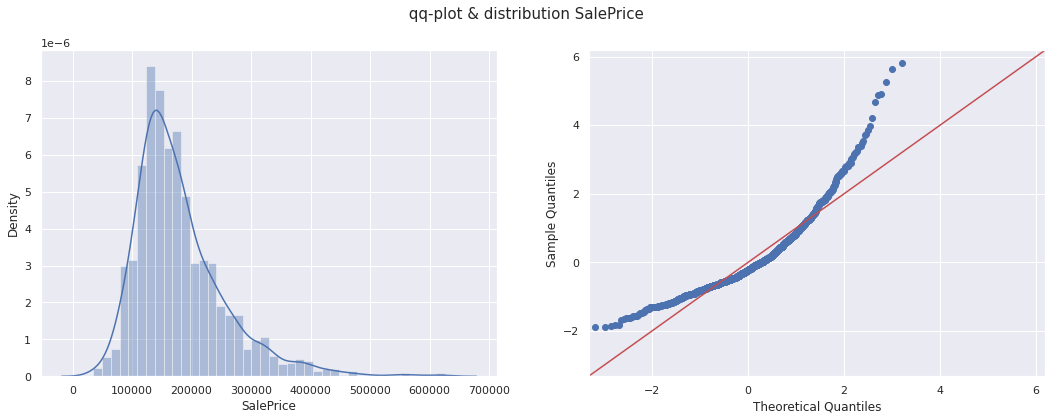

In [338]:
import statsmodels.api as sm
import scipy.stats as stats

# 線形モデルでは正規分布になっていることが望ましい -> 対数変換を検討してみる

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize=15)

sns.distplot(home_data["SalePrice"], kde=True, hist=True, ax=ax[0])
sm.qqplot(home_data["SalePrice"], stats.t, distargs=(4,), fit=True, line="45", ax=ax[1])
plt.show()

In [339]:
# 売却価格の概要をみてみる
print(home_data["SalePrice"].describe())
print(f"歪度: {round(home_data['SalePrice'].skew(),4)}" )  # 0に近いほど左右対称
print(f"尖度: {round(home_data['SalePrice'].kurt(),4)}" )  # 0に近いほど正規分布に近づく

count      1458.000000
mean     180140.566529
std       76645.846478
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      213875.000000
max      625000.000000
Name: SalePrice, dtype: float64
歪度: 1.5673
尖度: 3.8949


- SalePrice : 販売価格
- GrLivArea : 地上の住居面積
- PoolQC : プールの品質
- MiscFeature : 他のカテゴリでカバーされていないその他の機能
- Alley : 住宅から路地へのアクセスタイプ
- Fence : フェンスの品質
- FireplaceQu : 暖炉の品質
- LotFrontage : 住居から通りへの距離
- GarageType, GarageFinish, GarageQual and GarageCond : ガレージ
- GarageYrBlt, GarageArea and GarageCars : ガレージ（数値情報）
- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 地下
- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 地下
- MasVnrArea and MasVnrType : 石積みベニア
- MSZoning : 販売の一般的な種類
- Utilities : ユーティリティ（電気、ガス、水道）のタイプ
- Functional : 住宅の機能 93%
- Electrical : 電気系統
- KitchenQual: キッチンの品質
- Exterior1st, Exterior2nd : 外装
- SaleType : 販売タイプ

### 多重共線性の確認

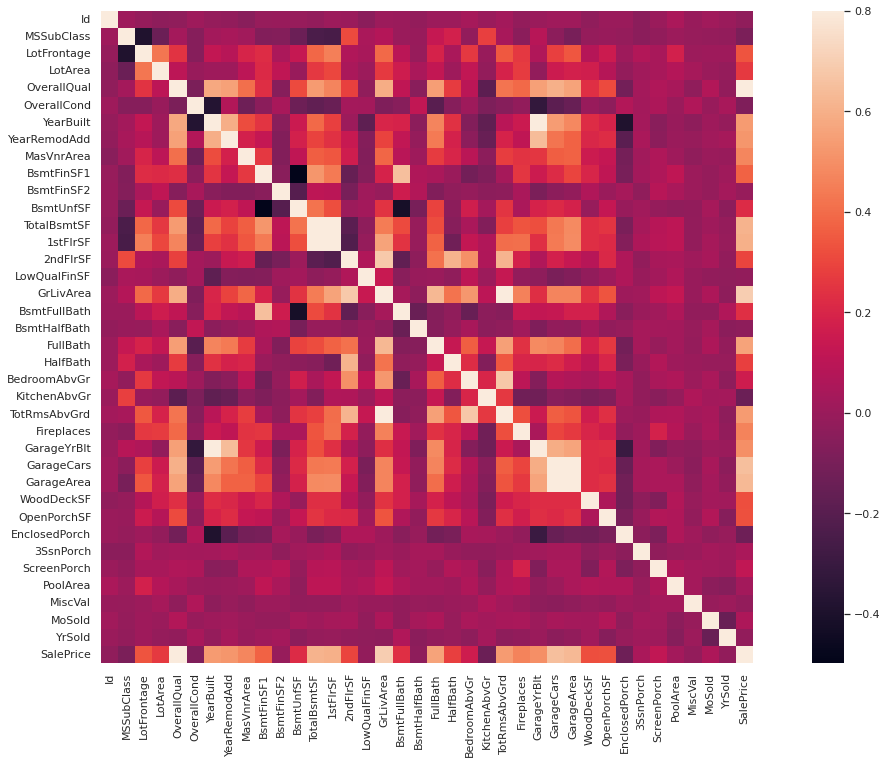

In [340]:
corrmat = home_data.corr()
f, ax = plt.subplots(figsize=(21, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

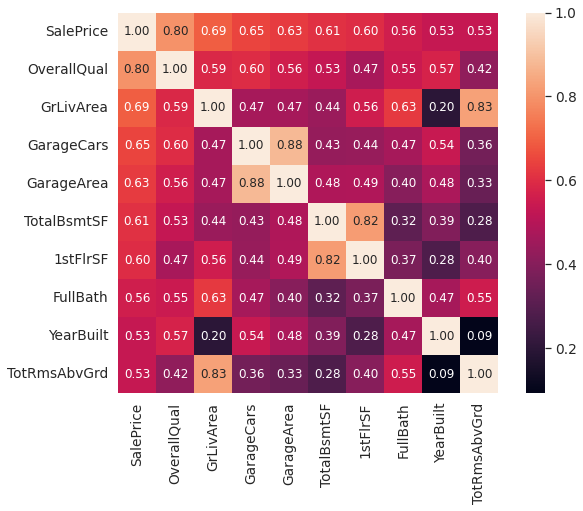

In [341]:
import numpy as np

# 上位に絞って表示
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(home_data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(10, 7))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [342]:
home_data['GarageArea']

0       548
1       460
2       608
3       642
4       836
       ... 
1455    460
1456    500
1457    252
1458    240
1459    276
Name: GarageArea, Length: 1458, dtype: int64

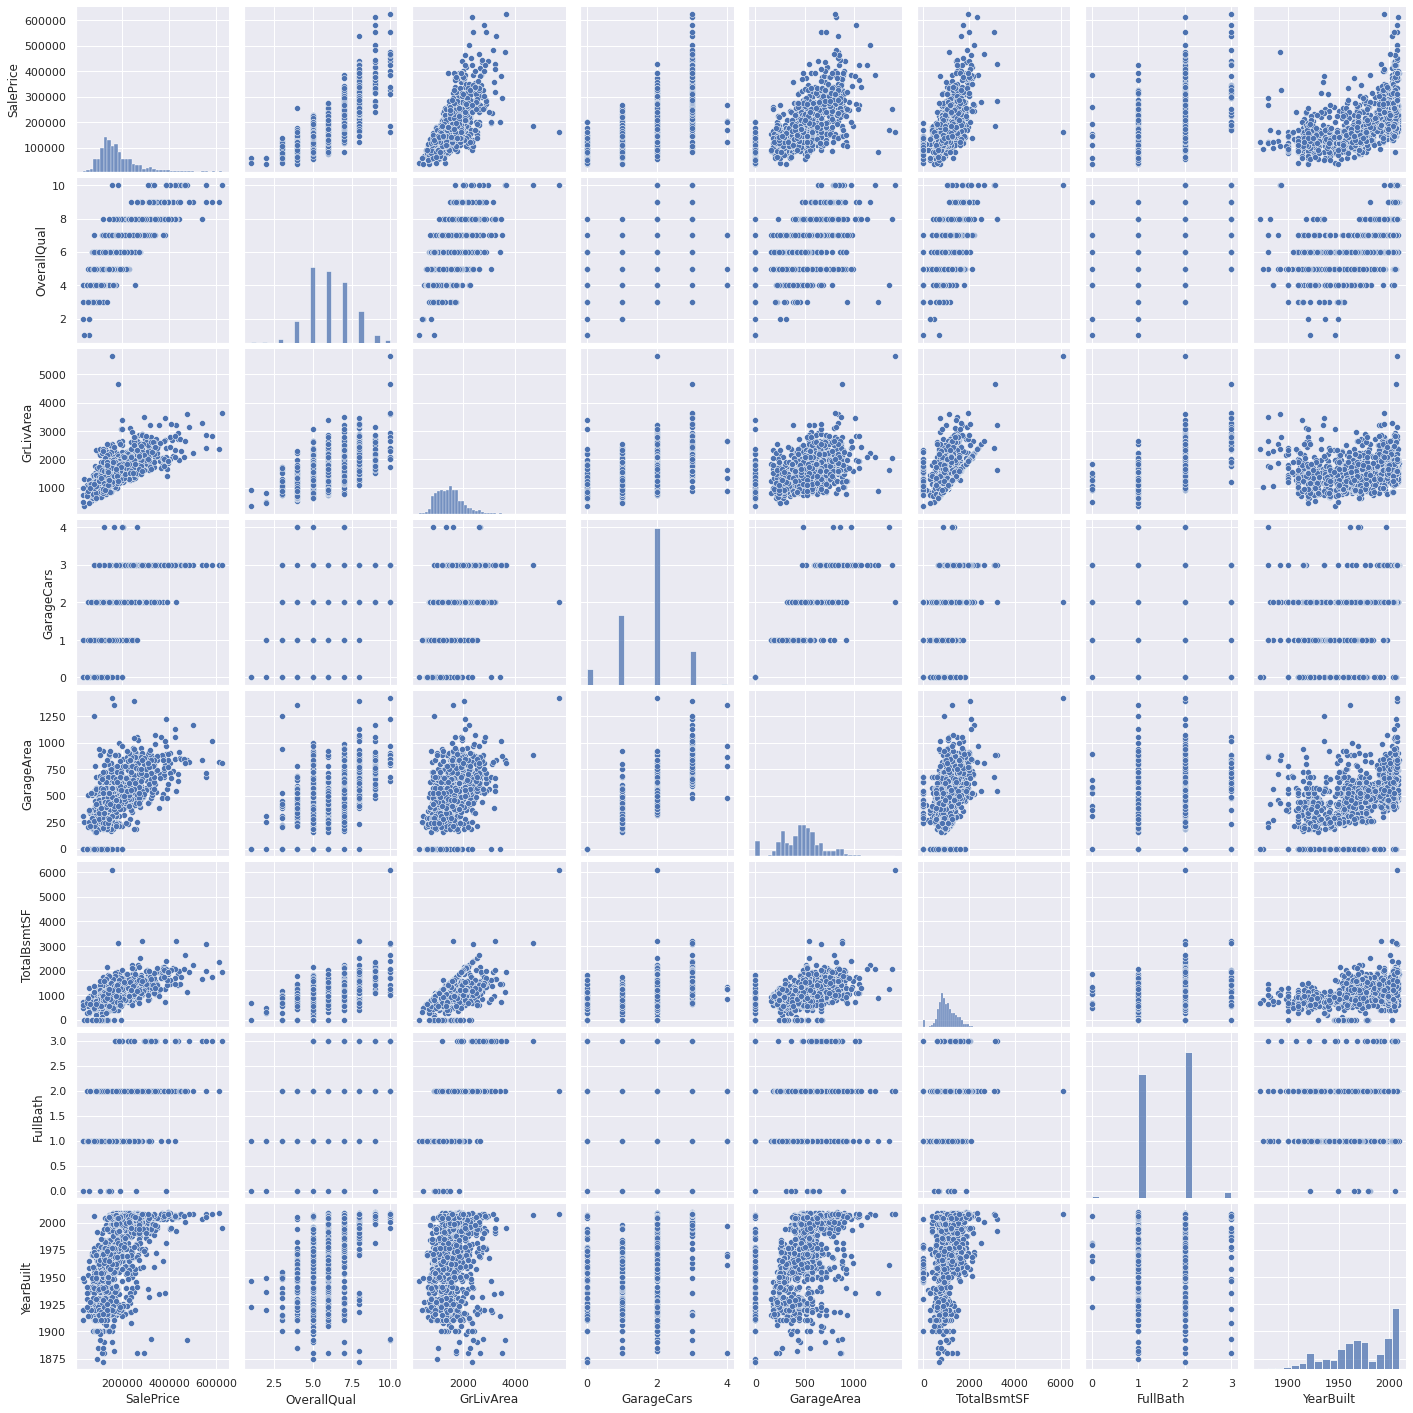

In [343]:
# 正の相関関係を炙り出す
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(home_data[cols], height=2.5)
plt.show();

### 欠損値の確認

In [344]:
total = home_data.isnull().sum().sort_values(ascending=False)
percent = (home_data.isnull().sum() / home_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1178,0.807956
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageYrBlt,81,0.055556
GarageCond,81,0.055556
GarageType,81,0.055556
GarageFinish,81,0.055556


In [345]:
# 欠損値が20%以上を保存（後でdropするため）
#drop_cols = missing_data.query('Percent>0.2').index
#drop_cols

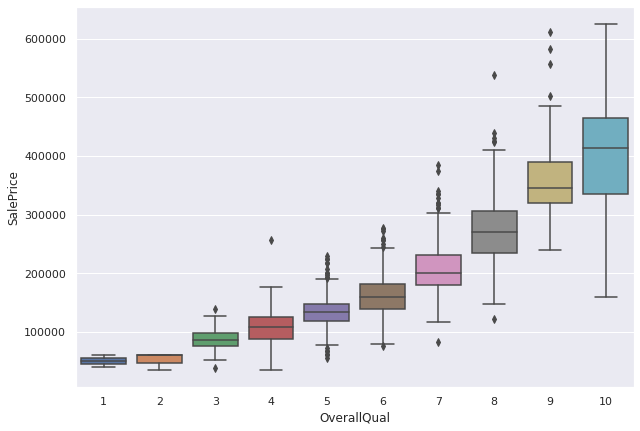

In [346]:
var = 'OverallQual'
f, ax = plt.subplots(figsize=(10, 7))
fig = sns.boxplot(x=var, y="SalePrice", data=home_data)
#fig.axis(ymin=0, ymax=800000);

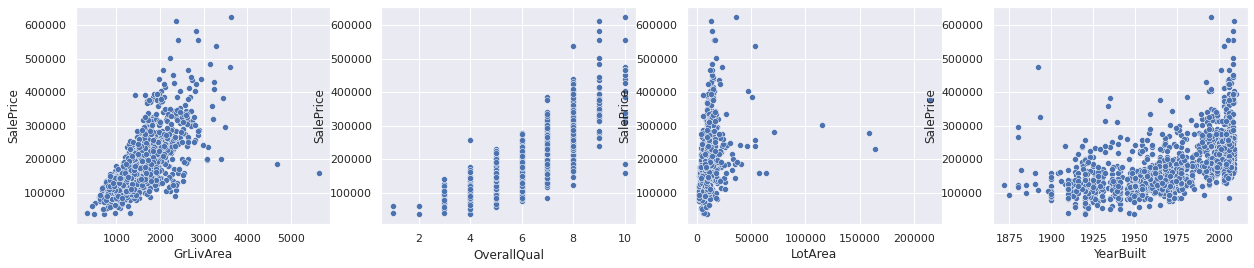

In [347]:
fig, ax = plt.subplots(1, 4, figsize=(21, 4))
#fig.suptitle(" GrLivArea, LotArea, YearBuilt - SalePrice ", fontsize=15)

sns.scatterplot(x=home_data['GrLivArea'], y=home_data['SalePrice'], ax=ax[0])   # 地上の広さ
#sns.scatterplot(x=home_data['TotalBsmtSF'], y=home_data['SalePrice'], ax=ax[1]) # 地下の広さ
sns.scatterplot(x=home_data['OverallQual'], y=home_data['SalePrice'], ax=ax[1]) # 素材・完成度
sns.scatterplot(x=home_data['LotArea'], y=home_data['SalePrice'], ax=ax[2])
sns.scatterplot(x=home_data['YearBuilt'], y=home_data['SalePrice'], ax=ax[3])  # 建設日
plt.show()


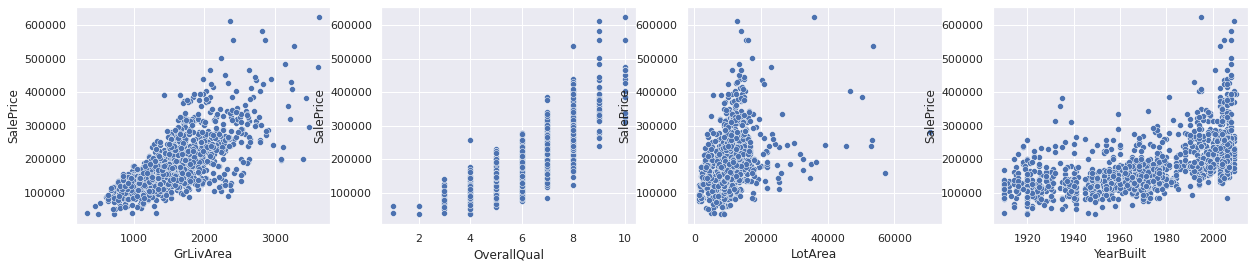

In [348]:
# 外れ値の削除
fig, ax = plt.subplots(1, 4, figsize=(21, 4))

var = 'GrLivArea'
drop_index = home_data[(home_data[var]>4000) & (home_data['SalePrice']<300000)].index
home_data = home_data.drop(drop_index)
sns.scatterplot(x=home_data[var], y=home_data['SalePrice'], ax=ax[0])

var = 'OverallQual'
#drop_index = home_data[var].index   # そのまま
#home_data = home_data.drop(drop_index)
sns.scatterplot(x=home_data[var], y=home_data['SalePrice'], ax=ax[1])

var = 'LotArea'
drop_index = home_data[home_data[var]>100000].index
home_data = home_data.drop(drop_index)
sns.scatterplot(x=home_data[var], y=home_data['SalePrice'], ax=ax[2])

var = 'YearBuilt'
drop_index = home_data[home_data[var]<1910].index
#drop_index = home_data[(home_data[var]<1910) & (home_data['SalePrice']>700000)].index
home_data = home_data.drop(drop_index)
#drop_index = home_data[(home_data['SalePrice']>400000)].index
#home_data = home_data.drop(drop_index)
sns.scatterplot(x=home_data[var], y=home_data['SalePrice'], ax=ax[3])
plt.show()

Text(0, 0.5, 'Neighborhood')

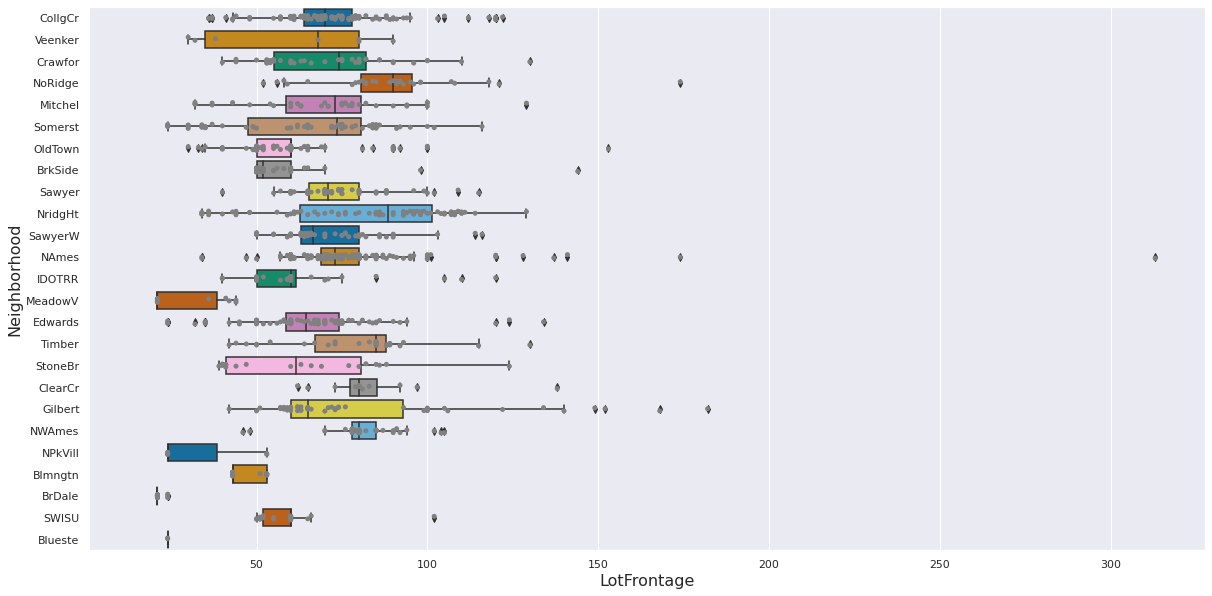

In [349]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.set_context(font_scale=5)

home_data_tmp = home_data.query('LotFrontage<500')
g = sns.boxplot(x='LotFrontage', y='Neighborhood', data=home_data_tmp, orient='h', palette='colorblind') # orient='h' h:横方向, v:縦方向
sns.stripplot(x='LotFrontage', y='Neighborhood', data=home_data_tmp, jitter=True, color='gray')
g.set(xlim=(1.0, None))
plt.xlabel('LotFrontage', fontsize=16)
plt.ylabel('Neighborhood', fontsize=16)
#g.set_title(f'2022年 {AI_PRED_FILE}', fontsize=17)


In [350]:
drop_index = home_data[home_data['LotFrontage']>200].index
home_data = home_data.drop(drop_index)
#sns.scatterplot(x=home_data['GrLivArea'], y=home_data['SalePrice'])

### TotalBsmtSF 地下の面積

In [351]:
home_data['TotalBsmtSF'].value_counts().sort_values()

951      1
1309     1
1328     1
1247     1
1085     1
        ..
1040    14
912     15
672     17
864     35
0       36
Name: TotalBsmtSF, Length: 703, dtype: int64

In [352]:
# ココらへんからデータをいじるので、コピーしてから使う
home_data_cp = home_data.copy()
test_data_cp = test_data.copy()

In [353]:
# Trainデータ
# 変数の型ごとに欠損値の扱いが異なるため、変数ごとに処理
for column in home_data_cp.columns:
    # dtypeがobjectの場合、文字列の変数
    if home_data_cp[column].dtype=='O':
        home_data_cp[column] = home_data_cp[column].fillna('None')
    # dtypeがint , floatの場合、数字の変数
    else:
        home_data_cp[column] = home_data_cp[column].fillna(0)

# Testデータ  カラム数が違うため別々に処理
# 変数の型ごとに欠損値の扱いが異なるため、変数ごとに処理
for column in test_data_cp.columns:
    # dtypeがobjectの場合、文字列の変数
    if test_data_cp[column].dtype=='O':
        test_data_cp[column] = test_data_cp[column].fillna('None')
    # dtypeがint , floatの場合、数字の変数
    else:
        test_data_cp[column] = test_data_cp[column].fillna(0)

In [354]:
# 特徴量エンジニアリング
# 特徴量エンジニアリングによりカラムを追加する関数
def add_new_columns(df):
    # 建物内の総面積 = 1階の面積 + 2階の面積 + 地下の面積
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]

    # 一部屋あたりの平均面積 = 建物の総面積 / 部屋数
    df['AreaPerRoom'] = df['TotalSF'] / df['TotRmsAbvGrd']

    # 築年数 + 最新リフォーム年 : この値が大きいほど値段が高くなりそう
    df['YearBuiltPlusRemod'] = df['YearBuilt'] + df['YearRemodAdd']

    # お風呂の総面積
    # Full bath : 浴槽、シャワー、洗面台、便器全てが備わったバスルーム
    # Half bath : 洗面台、便器が備わった部屋)(シャワールームがある場合もある)
    # シャワーがない場合を想定してHalf Bathには0.5の係数をつける
    HALF_BATH_COEF = .5
    df['TotalBathrooms'] = (df['FullBath'] + (HALF_BATH_COEF * df['HalfBath']) + \
                            df['BsmtFullBath'] + (HALF_BATH_COEF * df['BsmtHalfBath']))

    # 合計の屋根付きの玄関の総面積 
    # Porch : 屋根付きの玄関 日本風にいうと縁側
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    # プールの有無
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    # 2階の有無
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    # ガレージの有無
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

    # 地下室の有無
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

    # 暖炉の有無
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# カラムを追加
add_new_columns(home_data_cp)
add_new_columns(test_data_cp)

In [355]:
# 欠損値が存在しないことをチェック
null_sum = home_data_cp.isnull().sum()
null_sum[null_sum>0]

Series([], dtype: int64)

In [356]:
null_sum = home_data_cp.isnull().sum()
null_sum[null_sum>0]

Series([], dtype: int64)

In [357]:
#df[df.columns[df.columns != 'b']]
#home_data_cp = home_data_cp[home_data_cp.columns[home_data_cp.columns != 'LotFrontage']]
#home_data_cp = home_data_cp[home_data_cp.columns[home_data_cp.columns != 'MasVnrArea']]
#home_data_cp = home_data_cp[home_data_cp.columns[home_data_cp.columns != 'GarageYrBlt']]

In [358]:
# ダミー変数化
# TrainデータとTestデータが別れている場合（実戦はこちらのほうが多い)、pandasのget_dummiesは特徴量が合わなくなる可能性が大いにある。
# sklearnの OneHotEncoder を使えば良い

#home_data_cp = pd.get_dummies(home_data_cp)

In [359]:
# 重要度が低そうな・・・
drop_cols = []

In [360]:
cols = ['TotalBsmtSF']
for col in cols:
    drop_cols.append(col)

In [361]:
# ベニア板と電気？
cols = ['MasVnrArea', 'MasVnrType', 'Electrical']
for col in cols:
    drop_cols.append(col)

In [362]:
# ガレージ系を調べる
#home_data[['GarageYrBlt', 'GarageCars', 'GarageArea', 'HasGarage', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].head()
## 必要無さそうなカラム
cols = ['GarageType', 'GarageQual', 'GarageCond'] 
for col in cols:
    drop_cols.append(col)

In [363]:
# Bsmt系を調べる バスルーム
#home_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'HasBsmt', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]
cols = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinType2']
for col in cols:
    drop_cols.append(col)

In [364]:
# TotalPorchSF で合計を出したので、元データは削除する
cols = ['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch']
for col in cols:
    drop_cols.append(col)
print('削除リスト：', drop_cols)

削除リスト： ['TotalBsmtSF', 'MasVnrArea', 'MasVnrType', 'Electrical', 'GarageType', 'GarageQual', 'GarageCond', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinType2', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch']


In [365]:
# 使用しない特徴量を削除する（Id 以外）
home_data_cp = home_data_cp.drop(columns=drop_cols)
test_data_cp = test_data_cp.drop(columns=drop_cols)

In [366]:
# object変数のカラム名をリストで取得
def type_list(i_df: pd.DataFrame) -> list:
    i = 0
    cat_list = []
    cols = i_df.columns
    
    for t in i_df.dtypes:
        if t == 'object':
            cat_list.append(cols[i])
        i += 1
        
    return cat_list

cats_list = type_list(home_data_cp.drop(['SalePrice'], axis=1))

In [367]:
# ラベルエンコーディング
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
#ohe.fit(home_data['Street'])
le = LabelEncoder()
for cat in cats_list:
    home_data_cp[f'{cat}_le'] = le.fit_transform(home_data_cp[cat])  # 訓練データ
    test_data_cp[f'{cat}_le'] = le.fit_transform(test_data_cp[cat])  # 提出用データ
# エンコード済みの特徴量を削除
home_data_cp.drop(columns=cats_list, inplace=True)
test_data_cp.drop(columns=cats_list, inplace=True)
#ohe.categories_
#ohe.get_feature_names_out()
#pd.DataFrame(ohe.transform(home_data))
home_data_cp

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalSF,AreaPerRoom,YearBuiltPlusRemod,TotalBathrooms,TotalPorchSF,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,MSZoning_le,Street_le,Alley_le,LotShape_le,LandContour_le,Utilities_le,LotConfig_le,LandSlope_le,Neighborhood_le,Condition1_le,Condition2_le,BldgType_le,HouseStyle_le,RoofStyle_le,RoofMatl_le,Exterior1st_le,Exterior2nd_le,ExterQual_le,ExterCond_le,Foundation_le,BsmtQual_le,BsmtCond_le,BsmtExposure_le,BsmtFinType1_le,Heating_le,HeatingQC_le,CentralAir_le,KitchenQual_le,Functional_le,FireplaceQu_le,GarageFinish_le,PavedDrive_le,PoolQC_le,Fence_le,MiscFeature_le,SaleType_le,SaleCondition_le
0,1,60,65.0,8450,7,5,2003,2003,706,0,150,856,854,0,1710,2,1,3,1,8,0,2003.0,2,548,0,0,0,2,2008,208500,2566,320.750000,4006,3.5,61,0,1,1,1,0,3,1,1,3,3,0,4,0,5,2,2,0,5,1,0,12,13,2,4,2,2,4,3,2,1,0,1,2,6,3,2,2,3,4,1,8,4
1,2,20,80.0,9600,6,8,1976,1976,978,0,284,1262,0,0,1262,2,0,3,1,6,1,1976.0,2,460,298,0,0,5,2007,181500,2524,420.666667,3952,2.5,298,0,0,1,1,1,3,1,1,3,3,0,2,0,24,1,2,0,2,1,0,8,8,3,4,1,2,4,1,0,1,0,1,3,6,5,2,2,3,4,1,8,4
2,3,60,68.0,11250,7,5,2001,2002,486,0,434,920,866,0,1786,2,1,3,1,6,1,2001.0,2,608,0,0,0,9,2008,223500,2706,451.000000,4003,3.5,42,0,1,1,1,1,3,1,1,0,3,0,4,0,5,2,2,0,5,1,0,12,13,2,4,2,2,4,2,2,1,0,1,2,6,5,2,2,3,4,1,8,4
3,4,70,60.0,9550,7,5,1915,1970,216,0,540,961,756,0,1717,1,0,3,1,7,1,1998.0,3,642,0,0,0,2,2006,140000,2473,353.285714,3885,2.0,307,0,1,1,1,1,3,1,1,0,3,0,0,0,6,2,2,0,5,1,0,13,15,3,4,0,4,1,3,0,1,2,1,2,6,2,3,2,3,4,1,8,0
4,5,60,84.0,14260,8,5,2000,2000,655,0,490,1145,1053,0,2198,2,1,4,1,9,1,2000.0,3,836,192,0,0,12,2008,250000,3343,371.444444,4000,3.5,276,0,1,1,1,1,3,1,1,0,3,0,2,0,15,2,2,0,5,1,0,12,13,2,4,2,2,4,0,2,1,0,1,2,6,5,2,2,3,4,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0,0,953,953,694,0,1647,2,1,3,1,7,1,1999.0,2,460,0,0,0,8,2007,175000,2600,371.428571,3999,2.5,40,0,1,1,1,1,3,1,1,3,3,0,4,0,8,2,2,0,5,1,0,12,13,3,4,2,2,4,3,6,1,0,1,3,6,5,2,2,3,4,1,8,4
1456,1457,20,85.0,13175,6,6,1978,1988,790,163,589,2073,0,0,2073,2,0,3,1,7,2,1978.0,2,500,349,0,0,2,2010,210000,3615,516.428571,3966,3.0,349,0,0,1,1,1,3,1,1,3,3,0,4,0,14,2,2,0,2,1,0,9,10,3,4,1,2,4,3,0,1,4,1,3,2,5,3,2,3,2,1,8,4
1457,1458,70,66.0,9042,7,9,1941,2006,275,0,877,1188,1152,0,2340,2,0,4,1,9,2,1941.0,1,252,0,0,2500,5,2010,266500,3492,388.000000,3947,2.0,60,0,1,1,1,1,3,1,1,3,3,0,4,0,6,2,2,0,5,1,0,5,5,0,2,4,4,1,3,2,1,0,1,2,6,2,2,2,3,0,3,8,4
1458,1459,20,68.0,9717,5,6,1950,1996,49,1029,0,1078,0,0,1078,1,0,2,1,5,0,1950.0,1,240,366,0,0,4,2010,142125,2156,431.200000,3946,2.0,478,0,0,1,1,0,3,1,1,3,3,0,4,0,12,2,2,0,2,3,0,8,8,3,4,1,4,4,2,2,1,2,1,2,6,3,3,2,3,4,1,8,4


In [368]:
test_data_cp

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,PoolArea,MiscVal,MoSold,YrSold,TotalSF,AreaPerRoom,YearBuiltPlusRemod,TotalBathrooms,TotalPorchSF,HasPool,Has2ndFloor,HasGarage,HasBsmt,HasFireplace,MSZoning_le,Street_le,Alley_le,LotShape_le,LandContour_le,Utilities_le,LotConfig_le,LandSlope_le,Neighborhood_le,Condition1_le,Condition2_le,BldgType_le,HouseStyle_le,RoofStyle_le,RoofMatl_le,Exterior1st_le,Exterior2nd_le,ExterQual_le,ExterCond_le,Foundation_le,BsmtQual_le,BsmtCond_le,BsmtExposure_le,BsmtFinType1_le,Heating_le,HeatingQC_le,CentralAir_le,KitchenQual_le,Functional_le,FireplaceQu_le,GarageFinish_le,PavedDrive_le,PoolQC_le,Fence_le,MiscFeature_le,SaleType_le,SaleCondition_le
0,1461,20,80.0,11622,5,6,1961,1961,468.0,144.0,270.0,896,0,0,896,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,6,2010,1778.0,355.600000,3922,1.0,260,0,0,1,1,0,3,1,1,3,3,0,4,0,12,1,2,0,2,1,0,11,13,3,4,1,4,4,3,5,0,4,1,4,7,3,3,2,2,2,1,9,4
1,1462,20,81.0,14267,6,6,1958,1958,923.0,0.0,406.0,1329,0,0,1329,1,1,3,1,6,0,1958.0,1.0,312.0,393,0,12500,6,2010,2658.0,443.000000,3916,1.5,429,0,0,1,1,0,4,1,1,0,3,0,0,0,12,2,2,0,2,3,0,12,14,3,4,1,4,4,3,0,0,4,1,2,7,3,3,2,2,4,0,9,4
2,1463,60,74.0,13830,5,5,1997,1998,791.0,0.0,137.0,928,701,0,1629,2,1,3,1,6,1,1997.0,2.0,482.0,212,0,0,3,2010,2557.0,426.166667,3995,2.5,246,0,1,1,1,1,4,1,1,0,3,0,4,0,8,2,2,0,4,1,0,11,13,3,4,2,2,4,3,2,0,2,1,4,7,5,0,2,2,2,1,9,4
3,1464,60,78.0,9978,6,6,1998,1998,602.0,0.0,324.0,926,678,0,1604,2,1,3,1,7,1,1998.0,2.0,470.0,360,0,0,6,2010,2530.0,361.428571,3996,2.5,396,0,1,1,1,1,4,1,1,0,3,0,4,0,8,2,2,0,4,1,0,11,13,3,4,2,4,4,3,2,0,0,1,2,7,2,0,2,2,4,1,9,4
4,1465,120,43.0,5005,8,5,1992,1992,263.0,0.0,1017.0,1280,0,0,1280,2,0,2,1,5,0,1992.0,2.0,506.0,0,0,0,1,2010,2560.0,512.000000,3984,2.0,226,0,0,1,1,0,4,1,1,0,1,0,4,0,22,2,2,4,2,1,0,6,6,2,4,2,2,4,3,0,0,0,1,2,7,3,2,2,2,4,1,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,546.0,546,546,0,1092,1,1,3,1,5,0,0.0,0.0,0.0,0,0,0,6,2006,1638.0,327.600000,3940,1.5,0,0,1,0,1,0,5,1,1,3,3,0,4,0,10,2,2,3,4,1,0,5,5,3,4,1,4,4,3,6,0,2,1,4,7,3,1,2,2,4,1,9,4
1455,2916,160,21.0,1894,4,5,1970,1970,252.0,0.0,294.0,546,546,0,1092,1,1,3,1,6,0,1970.0,1.0,286.0,0,0,0,4,2006,1638.0,273.000000,3940,1.5,24,0,1,1,1,0,5,1,1,3,3,0,4,0,10,2,2,4,4,1,0,5,5,3,4,1,4,4,3,5,0,4,1,4,7,3,3,2,2,4,1,9,0
1456,2917,20,160.0,20000,5,7,1960,1996,1224.0,0.0,0.0,1224,0,0,1224,1,0,4,1,7,1,1960.0,2.0,576.0,474,0,0,9,2006,2448.0,349.714286,3956,2.0,474,0,0,1,1,1,4,1,1,3,3,0,4,0,11,2,2,0,2,1,0,11,13,3,4,1,4,4,3,0,0,0,1,4,7,5,3,2,2,4,1,9,0
1457,2918,85,62.0,10441,5,5,1992,1992,337.0,0.0,575.0,970,0,0,970,1,0,3,1,6,0,0.0,0.0,0.0,80,0,700,7,2006,1882.0,313.666667,3984,1.5,112,0,0,0,1,0,4,1,1,3,3,0,4,0,11,2,2,0,5,1,0,6,15,3,4,2,2,4,0,2,0,4,1,4,7,3,1,2,2,2,3,9,4


In [369]:
# SalePriceLogに対数変換した値を入れる。説明の都合上新たなカラムを作る
home_data_cp['SalePriceLog'] = np.log(home_data_cp['SalePrice'])

# 対数変換後のヒストグラム、歪度、尖度
#sns.set(rc = {'figure.figsize':(10, 5)})
#sns.distplot(home_data_cp['SalePriceLog'])
print(f"歪度: {round(home_data_cp['SalePriceLog'].skew(),4)}")
print(f"尖度: {round(home_data_cp['SalePriceLog'].kurt(),4)}")

歪度: 0.0458
尖度: 0.7292


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


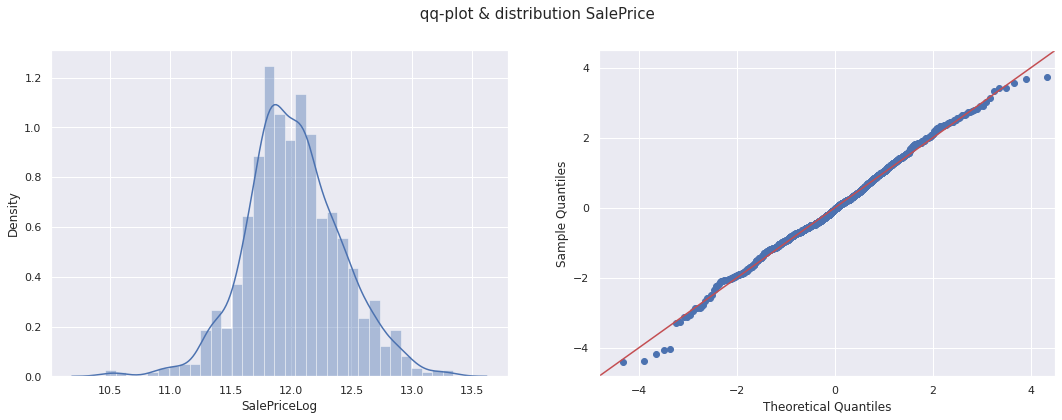

In [370]:
fig, ax = plt.subplots(1,2, figsize=(18, 6))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize=15)

sns.distplot(home_data_cp["SalePriceLog"], kde=True, hist=True, ax=ax[0])
sm.qqplot(home_data_cp["SalePriceLog"], stats.t, distargs=(4,), fit=True, line="45", ax=ax[1])
plt.show()

In [371]:
# 再度元に戻す
#home_data = home_data_cp.copy()
#test_data = test_data_cp.copy()

In [372]:
home_data_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1421 non-null   int64  
 1   MSSubClass          1421 non-null   int64  
 2   LotFrontage         1421 non-null   float64
 3   LotArea             1421 non-null   int64  
 4   OverallQual         1421 non-null   int64  
 5   OverallCond         1421 non-null   int64  
 6   YearBuilt           1421 non-null   int64  
 7   YearRemodAdd        1421 non-null   int64  
 8   BsmtFinSF1          1421 non-null   int64  
 9   BsmtFinSF2          1421 non-null   int64  
 10  BsmtUnfSF           1421 non-null   int64  
 11  1stFlrSF            1421 non-null   int64  
 12  2ndFlrSF            1421 non-null   int64  
 13  LowQualFinSF        1421 non-null   int64  
 14  GrLivArea           1421 non-null   int64  
 15  FullBath            1421 non-null   int64  
 16  HalfBa

In [373]:
# 最終的にDropするカラムの（再）指定
# Id はSubmissionsを作成する時に使うので、test_data用に残しておいた
drop_cols = ['Id']

In [374]:
y = home_data_cp.SalePriceLog

# Create X (After completing the exercise, you can return to modify this line!)
# 
features = home_data_cp.columns
#features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'SalePrice', 'SalePriceLog']

# Select columns corresponding to features, and preview the data
X = home_data_cp[features]
X = X.drop(columns=drop_cols)
X = X.drop(columns=['SalePrice', 'SalePriceLog'])
#X.head()

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=1)

In [375]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(val_X, val_y, reference=lgb_train)

In [376]:
params = {'objective': 'regression',
             'metric': 'rmse',
          #'max_depth':  7,
         'num_leaves':  31,
      'boosting_type': 'gbdt',
         }
early_stopping_rounds=20
verbose_eval=100
model = lgb.train(params,
                  lgb_train,
                  valid_sets=lgb_eval,
                  num_boost_round=5000,
                  callbacks=[
                    lgb.reset_parameter(learning_rate=lambda iter: 0.05* (0.99 ** iter)),
                    lgb.early_stopping(stopping_rounds=early_stopping_rounds,
                                       verbose=True), # early_stopping用コールバック関数
                    lgb.log_evaluation(verbose_eval)]
                 )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3320
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 66
[LightGBM] [Info] Start training from score 12.028405
Training until validation scores don't improve for 20 rounds
[100]	valid_0's rmse: 0.14052
[200]	valid_0's rmse: 0.135923
[300]	valid_0's rmse: 0.13516
[400]	valid_0's rmse: 0.135025
[500]	valid_0's rmse: 0.13497
[600]	valid_0's rmse: 0.134947
[700]	valid_0's rmse: 0.134939
[800]	valid_0's rmse: 0.134937
[900]	valid_0's rmse: 0.134936
[1000]	valid_0's rmse: 0.134936
[1100]	valid_0's rmse: 0.134936
[1200]	valid_0's rmse: 0.134936
[1300]	valid_0's rmse: 0.134936
[1400]	valid_0's rmse: 0.134936
[1500]	valid_0's rmse: 0.134936
[1600]	valid_0's rmse: 0.134936
Early stopping, best iteration

<AxesSubplot:xlabel='importance'>

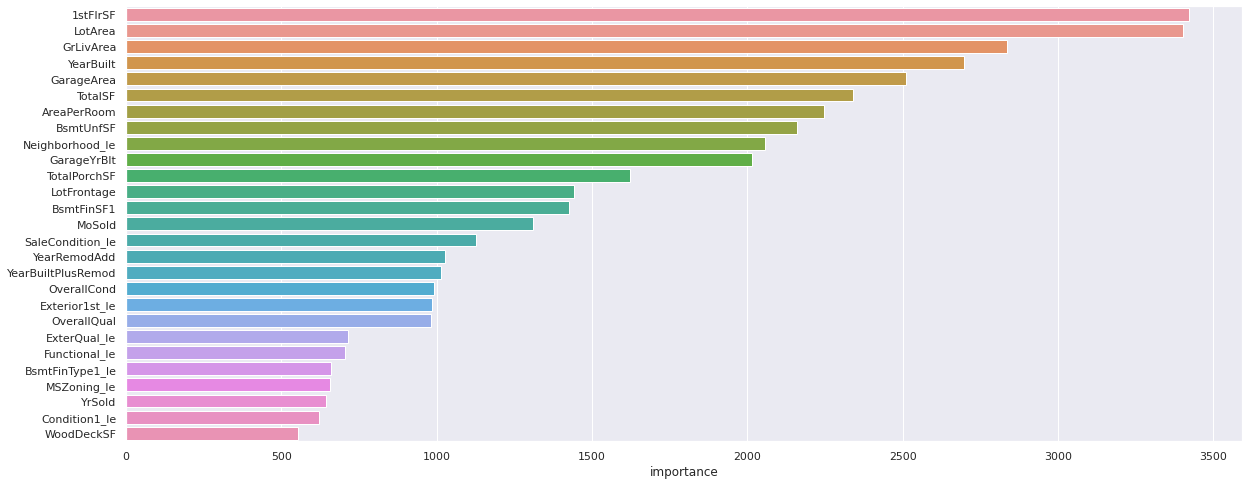

In [377]:
# 特徴量の重要度の確認
model.feature_importance()
fti = pd.DataFrame(model.feature_importance(), index=train_X.columns)
fti.columns = ['importance']
fti_sort = fti.sort_values('importance', ascending=False)

BOTTOM_INDEX_NO = 27
sns.set(rc = {'figure.figsize':(20, 8)})
sns.barplot(y=fti_sort.index[:BOTTOM_INDEX_NO], x='importance', data=fti_sort.iloc[:BOTTOM_INDEX_NO])

In [378]:
fti_sort.head(BOTTOM_INDEX_NO)

,importance
1stFlrSF,3421
LotArea,3403
GrLivArea,2835
YearBuilt,2696
GarageArea,2511
TotalSF,2341
AreaPerRoom,2245
BsmtUnfSF,2160
Neighborhood_le,2056
GarageYrBlt,2015


In [379]:
'''# このカラムで再度、訓練する
fti_sort.index[:BOTTOM_INDEX_NO]
'''

'# このカラムで再度、訓練する\nfti_sort.index[:BOTTOM_INDEX_NO]\n'

In [380]:
'''selected_cols = ['AreaPerRoom', 'GrLivArea', 'LotArea', 'BsmtUnfSF', 'GarageArea',
       'GarageYrBlt', 'YearBuilt', '1stFlrSF', 'BsmtFinSF1',
       'YearBuiltPlusRemod', 'WoodDeckSF', 'TotalBsmtSF', 'Neighborhood_le',
       'LotFrontage', 'SaleCondition_le', 'TotalSF', 'MoSold', 'MasVnrArea',
       'TotalPorchSF', 'Condition1_le', 'BsmtFinType1_le', 'Exterior1st_le',
       'YrSold', 'GarageFinish_le', 'ScreenPorch', 'YearRemodAdd',
       'BedroomAbvGr',
       'Id']
'''
#test_X = test_data[test_data.columns[test_data.columns != 'SalePrice']]
test_X = test_data_cp[test_data_cp.columns]
#test_X = test_data_cp[selected_cols]
test_X = test_X.drop(columns=drop_cols)
test_preds = model.predict(test_X)

In [381]:
#test_data_cp.columns

In [382]:
'''from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

def lasso_tuning(train_x, train_y):
    # alphaパラメータのリスト
    param_list = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] 

    for cnt, alpha in enumerate(param_list):
        # パラメータを設定したラッソ回帰モデル
        lasso = Lasso(alpha=alpha) 
        # パイプライン生成
        pipeline = make_pipeline(StandardScaler(), lasso)

        # 学習データ内でホールドアウト検証のために分割 テストデータの割合は0.3 seed値を0に固定
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)

        # 学習
        pipeline.fit(X_train,y_train)

        # RMSE(平均誤差)を計算
        train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
        test_rmse  = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
        # ベストパラメータを更新
        if (cnt == 0) or (best_score > test_rmse):
            best_score = test_rmse
            best_param = alpha
        else:
            pass

    # ベストパラメータのalphaと、そのときのMSEを出力
    print('alpha : ' + str(best_param))
    print('test score is : ' +str(round(best_score,4)))

    # ベストパラメータを返却
    return best_param

# best_alphaにベストパラメータのalphaが渡される。
best_alpha = lasso_tuning(train_X, train_y)
'''

"from sklearn.preprocessing import StandardScaler\nfrom sklearn.linear_model import Lasso\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.metrics import mean_squared_error\n\ndef lasso_tuning(train_x, train_y):\n    # alphaパラメータのリスト\n    param_list = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] \n\n    for cnt, alpha in enumerate(param_list):\n        # パラメータを設定したラッソ回帰モデル\n        lasso = Lasso(alpha=alpha) \n        # パイプライン生成\n        pipeline = make_pipeline(StandardScaler(), lasso)\n\n        # 学習データ内でホールドアウト検証のために分割 テストデータの割合は0.3 seed値を0に固定\n        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)\n\n        # 学習\n        pipeline.fit(X_train,y_train)\n\n        # RMSE(平均誤差)を計算\n        train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))\n        test_rmse  = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))\n        # ベストパラメータを更新\n        if (cnt == 0) or (best_score > test_rmse):\n  

In [383]:
'''# ラッソ回帰モデルにベストパラメータを設定
lasso = Lasso(alpha = best_alpha)
# パイプラインの作成
pipeline = make_pipeline(StandardScaler(), lasso)
# 学習
pipeline.fit(train_X, train_y)
'''

'# ラッソ回帰モデルにベストパラメータを設定\nlasso = Lasso(alpha = best_alpha)\n# パイプラインの作成\npipeline = make_pipeline(StandardScaler(), lasso)\n# 学習\npipeline.fit(train_X, train_y)\n'

In [384]:
'''test_X = test_data[test_data.columns[test_data.columns != 'SalePrice']]
test_preds = pipeline.predict(test_X)
'''

"test_X = test_data[test_data.columns[test_data.columns != 'SalePrice']]\ntest_preds = pipeline.predict(test_X)\n"

In [385]:
'''# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))
'''

'# Define a random forest model\nrf_model = RandomForestRegressor(random_state=1)\nrf_model.fit(train_X, train_y)\nrf_val_predictions = rf_model.predict(val_X)\nrf_val_mae = mean_absolute_error(rf_val_predictions, val_y)\n\nprint("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))\n'

# Train a model for the competition

The code cell above trains a Random Forest model on **`train_X`** and **`train_y`**.  

Use the code cell below to build a Random Forest model and train it on all of **`X`** and **`y`**.

In [386]:
'''# To improve accuracy, create a new Random Forest model which you will train on all training data
rf_model_on_full_data = RandomForestRegressor(random_state=1)

# fit rf_model_on_full_data on all data from the training data
rf_model_on_full_data.fit(train_X, train_y)
'''

'# To improve accuracy, create a new Random Forest model which you will train on all training data\nrf_model_on_full_data = RandomForestRegressor(random_state=1)\n\n# fit rf_model_on_full_data on all data from the training data\nrf_model_on_full_data.fit(train_X, train_y)\n'

Now, read the file of "test" data, and apply your model to make predictions.

In [387]:
'''
# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
#test_X = test_data[features]
test_X = test_data[test_data.columns[test_data.columns != 'SalePrice']]

# make predictions which we will submit. 
#test_preds = rf_model_on_full_data.predict(test_X)
test_preds = rf_model.predict(test_X)
'''

"\n# create test_X which comes from test_data but includes only the columns you used for prediction.\n# The list of columns is stored in a variable called features\n#test_X = test_data[features]\ntest_X = test_data[test_data.columns[test_data.columns != 'SalePrice']]\n\n# make predictions which we will submit. \n#test_preds = rf_model_on_full_data.predict(test_X)\ntest_preds = rf_model.predict(test_X)\n"

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 0.2979
尖度: 0.3291


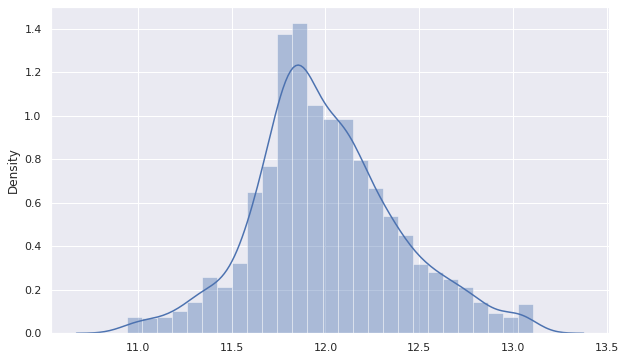

In [388]:
# 予測結果のプロット
sns.set(rc = {'figure.figsize':(10, 6)})
sns.distplot(test_preds)
# 歪度と尖度
print(f"歪度: {round(pd.Series(test_preds).skew(),4)}" )
print(f"尖度: {round(pd.Series(test_preds).kurt(),4)}" )

In [389]:
#test_preds = np.array(test_preds, dtype=np.float128)

歪度: 1.5415
尖度: 2.8304


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count      1459.000000
mean     176612.934102
std       74999.752936
min       56499.428745
25%      129053.678462
50%      155594.253627
75%      204692.378810
max      492648.951821
dtype: float64

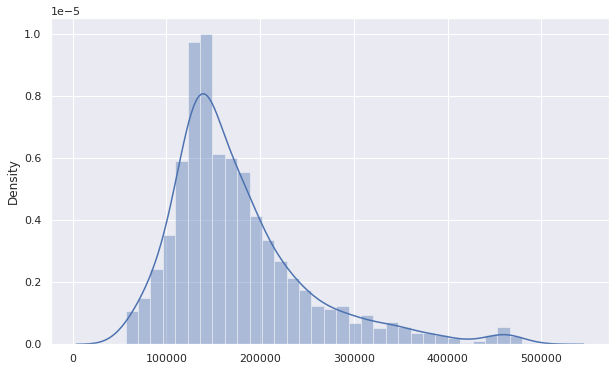

In [390]:
# 目的変数にlogを取ったので元に戻す

pred_exp = np.exp(test_preds)  # 指数変換
# 指数変換した予測結果をプロット
#sns.distplot(pred_exp)
sns.distplot(pred_exp)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred_exp).skew(),4)}")
print(f"尖度: {round(pd.Series(pred_exp).kurt(),4)}")
pd.Series(pred_exp).describe()

In [391]:
# (元データ)歪度と尖度
print('- 訓練データ')
print(f"歪度: {round(pd.Series(home_data['SalePrice']).skew(),4)}" )
print(f"尖度: {round(pd.Series(home_data['SalePrice']).kurt(),4)}" )
home_data['SalePrice'].describe()

- 訓練データ
歪度: 1.5722
尖度: 3.9839


count      1421.000000
mean     180310.303308
std       76259.304377
min       34900.000000
25%      130000.000000
50%      163990.000000
75%      213500.000000
max      625000.000000
Name: SalePrice, dtype: float64

Before submitting, run a check to make sure your `test_preds` have the right format.

In [392]:
# Check your answer (To get credit for completing the exercise, you must get a "Correct" result!)
#step_1.check()
#step_1.solution()

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [393]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': pred_exp})
output.to_csv('submission.csv', index=False)

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://i.imgur.com/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*